In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fenics import *
from dolfin import *
import pyvista as pv
import fenics as fe
import ufl

In [2]:
data=np.load("./all_data_m.npy",allow_pickle=True)
d=data.reshape(120960,6,24,32)
print(d.shape)

(120960, 6, 24, 32)


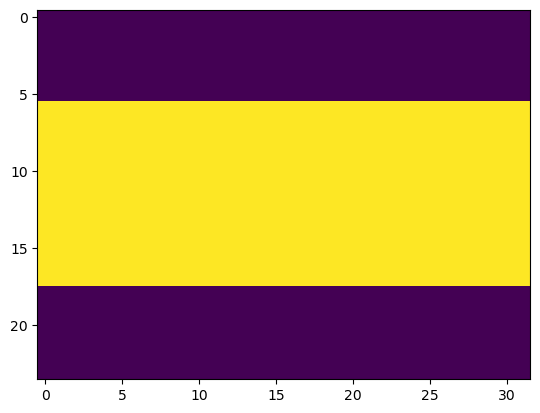

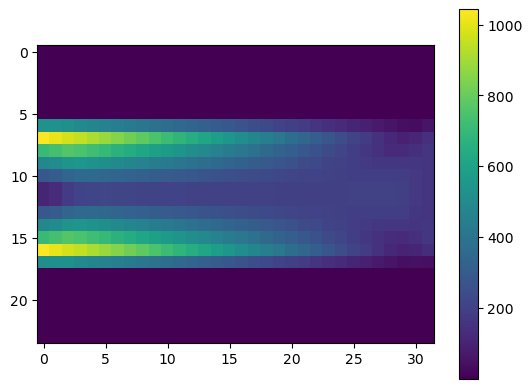

In [3]:
n=10220
# n=100000
dn=d[n]
plt.imshow(dn[0])
plt.show()
plt.imshow(dn[3])

plt.imshow(dn[-1])
plt.colorbar()
plt.show()


In [11]:
binary_array = dn[0]

# Add a third dimension to the binary array
binary_image = binary_array[np.newaxis, :, :]

# Create an image data object

grid = pv.wrap(binary_image.T)

# Use threshold to create a mesh
mesh = grid.threshold([0.5, 1.0]).triangulate()

# Visualize the mesh
mesh.plot(show_edges=True)

vtk_path = "quad_mesh.vtk"
mesh.save(vtk_path)

# import meshio
# mesh = meshio.read("quad_mesh.vtk")

# #save as xml

# mesh.points=mesh.points[:,:2]


# meshio.write("quad_mesh.xdmf", mesh)

Widget(value="<iframe src='http://localhost:39209/index.html?ui=P_0x7f8294bdbf50_2&reconnect=auto' style='widt…

UnstructuredGrid (0x7f8294b2fb80)
  N Cells:    806
  N Points:   448
  X Bounds:   0.000e+00, 3.100e+01
  Y Bounds:   5.000e+00, 1.800e+01
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   1

In [5]:
f = XDMFFile('quad_mesh.xdmf')
mesh_l=Mesh()
f.read(mesh_l)
mesh_l.coordinates().shape

(448, 2)

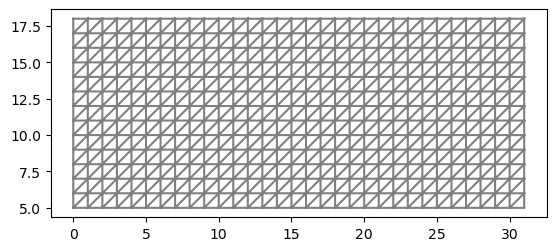

In [6]:

mesh = mesh_l
plot(mesh)

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.889e+06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 3.042e+06 (tol = 1.000e-10) r (rel) = 7.822e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.025e+02 (tol = 1.000e-10) r (rel) = 2.636e-05 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 2.102e-05 (tol = 1.000e-10) r (rel) = 5.405e-12 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
0.0740062678237691


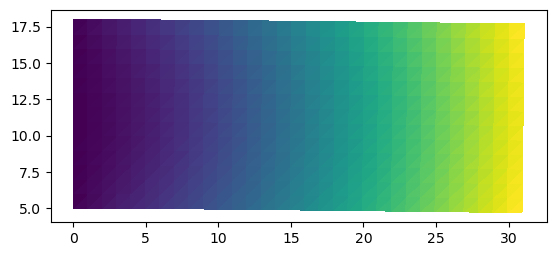

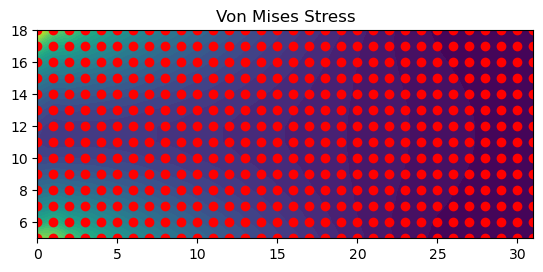

In [ ]:
def left_side(y, on_boundary):
    return (on_boundary and fe.near(y[0], 0.0))

def right_side(y, on_boundary):
    return (on_boundary and fe.near(y[0], 31.0))


# Strain function
def epsilon(u):
    return 0.5*(fe.grad(u) + fe.grad(u).T)


# Stress function
def sigma(u):
    return lmbda*fe.div(u)*fe.Identity(2) + 2*mu*epsilon(u)

E = 10.0e9
mu = 0.3*E
rho_0 = 200.0

# Load
g_int = 1e7
b_int = -1000.0

boundaries = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

top = fe.AutoSubDomain(lambda x: fe.near(x[1], 1.0))

top.mark(boundaries, 1)
ds = fe.ds(subdomain_data=boundaries)

# --------------------
# Function spaces
# --------------------
V = fe.VectorFunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)
u = fe.Function(V)

g = fe.Constant((0.0, g_int))
b = fe.Constant((0.0, b_int))

# g = TopLoad(0.0, g_int, degree=0)
# b = TopLoad(0.0, b_int, degree=0)

N = fe.Constant((0.0, 10.0))

aa, bb, cc, dd, ee = 0.5*mu, 0.0, 0.0, mu, -1.5*mu

# --------------------
# Boundary conditions
# --------------------
bc = fe.DirichletBC(V, fe.Constant((0.0, 0.0)), left_side)

# --------------------
# Weak form
# --------------------
I = fe.Identity(2)
F = I + fe.grad(u)  # Deformation gradient
C = F.T*F  # Right Cauchy-Green tensor
J = fe.det(F)  # Determinant of deformation fradient

#psi = (aa*fe.tr(C) + bb*fe.tr(ufl.cofac(C)) + cc*J**2 - dd*fe.ln(J))*fe.dx - fe.dot(b, u)*fe.dx + fe.inner(f, u)*ds(1)
n = fe.dot(ufl.cofac(F), N)
surface_def = fe.sqrt(fe.inner(n, n))
psi = (aa*fe.inner(F, F) + ee - dd*fe.ln(J))*fe.dx - rho_0*J*fe.dot(b, u)*fe.dx + surface_def*fe.inner(g, u)*ds(1)

# --------------------
# Solver
# --------------------
Form = fe.derivative(psi, u, u_test)
Jac = fe.derivative(Form, u, u_tr)

problem = fe.NonlinearVariationalProblem(Form, u, bc, Jac)
solver = fe.NonlinearVariationalSolver(problem)
prm = solver.parameters
# prm["newton_solver"]["error_on_convergence"] = False
#fe.solve(Form == 0, u, bc, J=Jac, solver_parameters={"error_on_convergence": False})
solver.solve()

print(np.amax(u.vector()[:]))

# --------------------
# Post-process
# --------------------
fe.plot(u, mode="displacement")
plt.show()
fe.plot(mesh)

for x in mesh.coordinates():
    if left_side:  # bottom boundary
        plt.plot(x[0], x[1], 'ro')  # Dirichlet BCs marked in red




I = fe.Identity(2)  # Identity tensor
F = I + fe.grad(u)  # Deformation gradient
C = F.T*F  # Right Cauchy-Green tensor
Ic = fe.tr(C)  # Trace of C
J = fe.det(F)  # Jacobian of F

# First Piola-Kirchhoff stress tensor
P = mu*(F - fe.inv(F).T) + mu*fe.ln(J)*fe.inv(F).T

# Compute Cauchy stress tensor
sigma = 1.0/J*P*F.T

# Project to function space
sigma_proj = project(sigma, TensorFunctionSpace(mesh, 'P', 1))

# To get the individual components of the stress tensor
sigma_11, sigma_12, sigma_21, sigma_22 = sigma_proj.split(deepcopy=True)

# Compute von Mises stress
von_Mises = project(sqrt(sigma_11**2 - sigma_11*sigma_22 + sigma_22**2 + 3*sigma_12**2), FunctionSpace(mesh, 'P', 1))

# Plot von Mises stress
c=plot(von_Mises, title='Von Mises Stress')
# plt.show()

plt.show()

vtkfile_sigma = fe.File('sigma.pvd')
vtkfile_sigma << sigma_proj

# Save von Mises stress to a VTK file
vtkfile_von_Mises = fe.File('von_Mises.pvd')
vtkfile_von_Mises << von_Mises

In [ ]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt

mesh = pv.Plane(center=(0.0, 0.0, 0.0),i_resolution=32, j_resolution=32,i_size=1.0, j_size=1.0)
mesh=mesh.triangulate()

x = np.linspace(-0.5, 0.5, 33)
y = np.linspace(-0.5, 0.5, 33)
x, y = np.meshgrid(x, y)
z = np.zeros_like(x)
grid = pv.StructuredGrid(x, y, z)


n=(0,0,1)
poly=pv.Polygon(center=(0,0,-0.5),normal=n,radius=0.4,n_sides=3).triangulate()
poly=poly.extrude(n,capping=True)
mesh_with_hole = mesh.clip_surface(poly,invert=True)

distances = np.linalg.norm(mesh_with_hole.points, axis=1)
mesh_with_hole["distances"] = distances

grid_with_distances = grid.interpolate(mesh_with_hole)
distances_2d = grid_with_distances.point_data["distances"].reshape((33, 33))
distances_2d = np.nan_to_num(distances_2d)


plotter = pv.Plotter()

plotter.add_mesh(mesh_with_hole, color="w", scalars="distances",show_edges=True)
# plotter.add_mesh(grid,opacity=0.5, color="r",show_edges=True)

plotter.show_axes_all()
plotter.show()


Widget(value="<iframe src='http://localhost:38893/index.html?ui=P_0x7f01a2876150_8&reconnect=auto' style='widt…

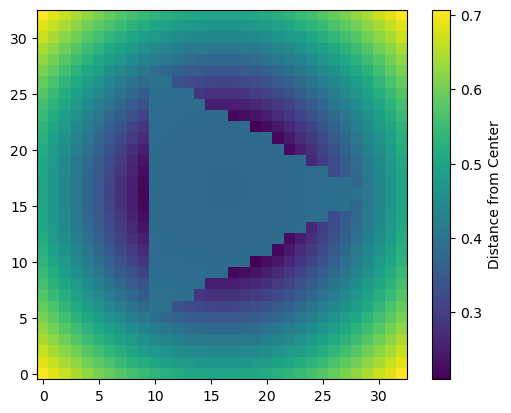

In [ ]:
plt.imshow(distances_2d, origin="lower")
plt.colorbar(label="Distance from Center")
plt.show()

In [ ]:
import pyvista as pv

# Load the data
grid = pv.read('von_Mises.pvd')

grid.plot()

Widget(value="<iframe src='http://localhost:45497/index.html?ui=P_0x7f71bcde3210_0&reconnect=auto' style='widt…

In [ ]:
from utils import *
from fenics import *
from dolfin import *
import pyvista as pv
import fenics as fe

m,p=make_mesh(center=(0.5,0.5,-0.5),radius=0.3,normal=(0.5,0.3,1),n_sides=6)
#number of bodies in m
print(len(m.split_bodies()))

save_xdmf(m)

pp=pv.Plotter()
pp.add_mesh(m,show_edges=True)
pp.add_mesh(p,show_edges=True)
pp.show()

1


Widget(value="<iframe src='http://localhost:45227/index.html?ui=P_0x7f1988f1bb10_12&reconnect=auto' style='wid…

In [ ]:
f = XDMFFile('m_t.xdmf')
mesh_l=Mesh()
f.read(mesh_l)
simulate(mesh_l,plot_displacement=True,plot_stress=
True,plot_mesh=True,E=20e5,mu=10e5,rho_0=200.0,g_int=1e6,b_int=-10)

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to open XDMF file.
*** Reason:  XDMF file "m_t.xdmf" does not exist.
*** Where:   This error was encountered inside XDMFFile.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  12ef077802cc9fad34cf984ec7af80585b44301b
*** -------------------------------------------------------------------------


# Testing generated data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob2

In [32]:
res_list= glob2.glob("./results/*.npy")
print(len(res_list))

n=10000
print(res_list[n])

data = np.load(res_list[n],allow_pickle=True)

geo=data[0]
lc1=data[1]
lc2=data[2]

res_list_n7 = glob2.glob("./results/**_7**.npy")
len(res_list_n7)


34732
./results/0.30000000000000004_0.30000000000000004_0.30000000000000004_90_7_-1_400.npy


7037

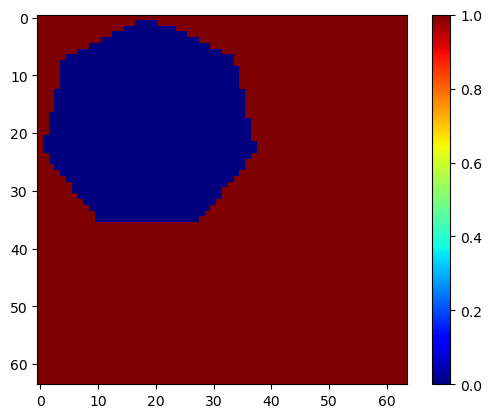

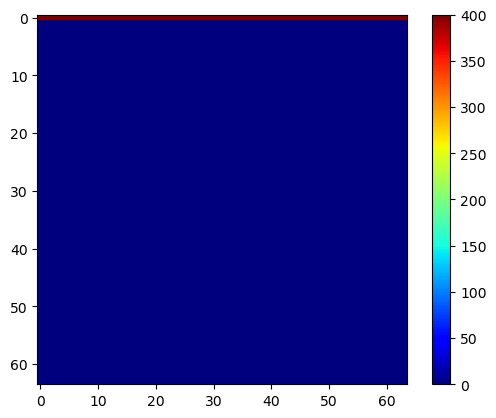

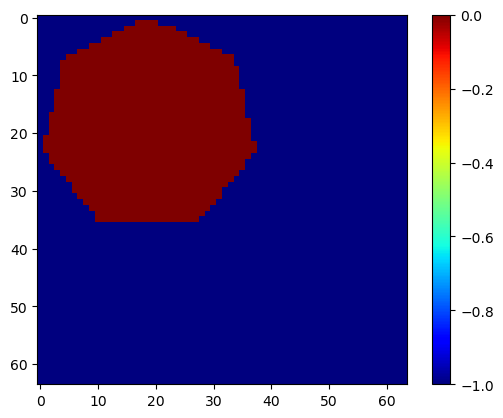

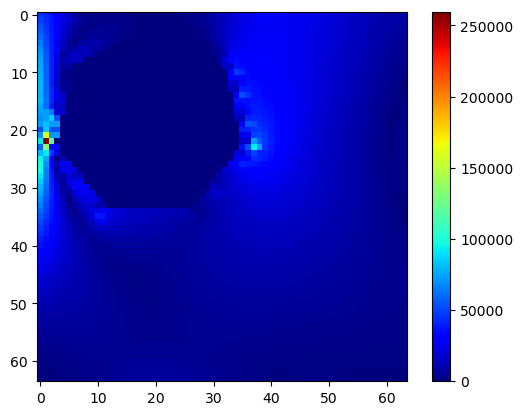

In [33]:
for i in range(len(data)):
    plt.imshow(data[i],cmap="jet")
    plt.colorbar()
    plt.savefig(f"r_{n}_{i}.png")
    plt.show()

In [35]:
data[1]

array([[400., 400., 400., ..., 400., 400., 400.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])